In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import glob
import os
from PIL import Image
import operator
from functools import reduce
import pickle
from tensorflow.python.keras.applications.xception import Xception, preprocess_input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing import image
%matplotlib inline

In [2]:

import seaborn as sns
sns.set()
#plt.rcParams['axes.titlesize'] = 22
plt.rcParams["figure.figsize"] = (10,7)

# Waves - model probabilities

In [3]:
test_images = glob.glob('data/IR/test/*/*.jpg')
len_test = len(test_images)
print(f"Number of images : {len_test}\nsample file_name : {test_images[0]}")

Number of images : 3000
sample file_name : data/IR/test/nonbreaking/147852629705.jpg


In [4]:
def wave_sort(path, I1, wave=[]):
    wave.append(I1)
    for i in range(1, 100):
        I2 = I1 + i
        if os.path.isfile(path+str(I2)+'.jpg'):
            wave = wave_sort(path, I2, wave)
            return wave
    return wave

def get_waves(file_path):
    waves = []
    files = sorted(glob.glob(file_path+'/*.jpg'))
    names = list(map(lambda x: int(x.split('/')[-1][:-4]), files))
    for i in names:
        try:
            if i not in waves[-1]:
                waves.append( wave_sort(file_path+'/', i, []) )
        except:
            waves.append( wave_sort(file_path+'/', i, []) )
            
    return waves

def plot_wave(path, wave):
    for i in wave:
        img = Image.open(path + '/' + str(i) + '.jpg')
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.pause(0.1)

In [5]:
plunge_waves = get_waves('data/IR/test/plunge')
spill_waves = get_waves('data/IR/test/spill')
non_waves = get_waves('data/IR/test/nonbreaking')

In [6]:
print(f"number of waves in test: \nplunge : {len(plunge_waves)}" + \
                      f"\nspill : {len(spill_waves)} " + \
                      f"\nnonbreaking : {len(non_waves)}")

number of waves in test: 
plunge : 3
spill : 23 
nonbreaking : 20


In [86]:
# Load the best models

base_model = Xception(weights='imagenet')
try:
    CNNmodel = Model(base_model.input, base_model.get_layer('avg_pool').output)	  
except:
    CNNmodel = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)
image_size = (299, 299)

with open('out/xception/models/IRclassifier.pickle', 'rb') as f:
    irmodel = pickle.load(f)
    
with open('out/xception/models/Floclassifier.pickle', 'rb') as f:
    flomodel = pickle.load(f)
    
with open('out/xception/models/IR2classifier.pickle', 'rb') as f:
    IR2model = pickle.load(f)

with open('out/xception/models/IR_flo_classifier.pickle', 'rb') as f:
    IRflomodel = pickle.load(f)
    
with open('out/xception/models/SPyclassifier.pickle', 'rb') as f:
    spymodel = pickle.load(f)
    
with open('out/xception/models/IRclassifier_imaug.pickle', 'rb') as f:
    irmodel_aug = pickle.load(f)
    
with open('out/xception/models/Floclassifier_imaug.pickle', 'rb') as f:
    flomodel_aug = pickle.load(f)
    
with open('out/xception/models/IR_flo_classifier_imaug.pickle', 'rb') as f:
    IRflomodel_aug = pickle.load(f)
    
with open('out/xception/models/IR2classifier_imaug.pickle', 'rb') as f:
    IR2model_aug = pickle.load(f)
    
#with open('out/xception/IR2flo_late_classifier_imaug.pickle', 'rb') as f:
#    latemodel_aug = pickle.load(f)

In [8]:
# brier score for multiple classes
def brier_mult(true, preds):
    return np.mean(np.sum((true-preds)**2, -1))

def inform(true, preds):
    tp = np.zeros(3)
    tn = np.zeros(3)
    fp = np.zeros(3)
    fn = np.zeros(3)
    
    for lab, pred in zip(true, preds):
        if lab == pred:
            tp[lab] += 1
            for i in range(len(tn)):
                if i != lab:
                    tn[i] += 1
        if lab != pred:
            fp[pred] += 1
            fn[lab] += 1
            for i in range(len(tn)):
                if i != pred or lab:
                    tn[i] += 1

    return (tp/(tp+fn)+tn/(tn+fp) -1)

# Load the features and labels for test images
def load_h5_test(feat_path, label_path):
    features = h5py.File(feat_path, 'r')
    labels = h5py.File(label_path, 'r')
    return features, labels

def make_preds(features, model):
    pred = model.predict_proba(features)
    return pred

In [87]:
# Load each models extracted features and labels
test_IR = h5py.File('out/xception/h5files/IRtestfeatures.h5', 'r')
test_IR = test_IR['dataset_1']
test_IRlab = h5py.File('out/xception/h5files/IRtestlabels.h5', 'r')
test_IRlab = test_IRlab['dataset_1']

test_flo = h5py.File('out/xception/h5files/Flotestfeatures.h5', 'r')
test_flo = test_flo['dataset_1']
test_flolab = h5py.File('out/xception/h5files/Flotestlabels.h5', 'r')
test_flolab = test_flolab['dataset_1']

test_IR2 = h5py.File('out/xception/h5files/IR2testfeatures.h5', 'r')
test_IR2 = test_IR2['dataset_1']
test_IR2lab = h5py.File('out/xception/h5files/IR2testlabels.h5', 'r')
test_IR2lab = test_IR2lab['dataset_1']

test_IRflo = h5py.File('out/xception/h5files/IR_flo_testfeatures.h5', 'r')
test_IRflo = test_IRflo['dataset_1']
test_IRflolab = h5py.File('out/xception/h5files/IR_flo_testlabels.h5', 'r')
test_IRflolab = test_IRflolab['dataset_1']

test_spyflo = h5py.File('out/xception/h5files/Spytestfeatures.h5', 'r')
test_spyflo = test_spyflo['dataset_1']
test_spyflolab = h5py.File('out/xception/h5files/Spytestlabels.h5', 'r')
test_spyflolab = test_spyflolab['dataset_1']

In [88]:
print("Informedness breakdown")
print("\t NB \t\t PL \t\t SP \t Informedness mean")
IRpreds = make_preds(test_IR, irmodel)
irinform = inform(test_IRlab[:], np.argmax(IRpreds, -1))
print("IR\t", irinform, np.mean(irinform))

flopreds = make_preds(test_flo, flomodel)
floinform = inform(test_flolab[:], np.argmax(flopreds, -1))
print("Flo\t", floinform, np.mean(floinform))

IR2preds = make_preds(test_IR2, IR2model)
ir2inform = inform(test_IR2lab[:], np.argmax(IR2preds, -1))
print("IR2\t", ir2inform, np.mean(ir2inform))

IRflopreds = make_preds(test_IRflo, IRflomodel)
IRfloinform = inform(test_IRflolab[:], np.argmax(IRflopreds, -1))
print("IRflo\t", IRfloinform, np.mean(IRfloinform))

spypreds = make_preds(test_spyflo, spymodel)
spyinform = inform(test_spyflolab[:], np.argmax(spypreds, -1))
print("SPy\t", spyinform, np.mean(spyinform))

Informedness breakdown
	 NB 		 PL 		 SP 	 Informedness mean
IR	 [0.86790203 0.41339523 0.79078056] 0.6906926066484314
Flo	 [0.8988656  0.57878565 0.81335196] 0.7636677362919103
IR2	 [0.89559865 0.42398363 0.83930621] 0.7196294948595882
IRflo	 [0.92550167 0.39863492 0.88048795] 0.7348748469711719
SPy	 [0.87880033 0.42636879 0.72328715] 0.6761520919390492


In [11]:
print("Informedness breakdown")
print("\t\t NB \t\t PL \t\t SP \t Informedness mean")
IRpreds = make_preds(test_IR, irmodel_aug)
irinform = inform(test_IRlab[:], np.argmax(IRpreds, -1))
print("IRaug\t\t", irinform, np.mean(irinform))

flopreds = make_preds(test_flo, flomodel_aug)
floinform = inform(test_flolab[:], np.argmax(flopreds, -1))
print("Floaug\t\t", floinform, np.mean(floinform))

IR2preds = make_preds(test_IR2, IR2model_aug)
ir2inform = inform(test_IRlab[:], np.argmax(IR2preds, -1))
print("IR2aug\t\t", ir2inform, np.mean(ir2inform))

IRflopreds = make_preds(test_IRflo, IRflomodel_aug)
IRfloinform = inform(test_IRflolab[:], np.argmax(IRflopreds, -1))
print("IRfloaug\t", IRfloinform, np.mean(IRfloinform))

#latepreds = make_preds(test_IRflo_late, latemodel_aug)
#lateinform = inform(test_IRflolab_late[:], np.argmax(latepreds, -1))
#print("Lateaug\t", lateinform, np.mean(lateinform))


Informedness breakdown
		 NB 		 PL 		 SP 	 Informedness mean
IRaug		 [0.84493145 0.46006472 0.76565574] 0.6902173031504741
Floaug		 [0.89819255 0.55110251 0.80856435] 0.7526198051013241
IR2aug		 [0.85111513 0.43817568 0.77848659] 0.689259130625449
IRfloaug	 [0.92785276 0.44932775 0.87146735] 0.7495492850115401


In [12]:
def one_hot(labels):
    onehot = np.zeros((len(labels), 3))
    for i, label in enumerate(labels):
        onehot[i, label] = 1
    return onehot

In [89]:
print("Brier Score IR \t\t", brier_mult(one_hot(test_IRlab), IRpreds))
print("Brier Score Flo \t", brier_mult(one_hot(test_flolab), flopreds))
print("Brier Score IR2 \t", brier_mult(one_hot(test_IR2lab), IR2preds))
print("Brier Score IR+Flo \t", brier_mult(one_hot(test_IRflolab), IRflopreds))
print("Brier Score SPyFlo \t", brier_mult(one_hot(test_spyflolab), spypreds))

Brier Score IR 		 0.13139000650993232
Brier Score Flo 	 0.10449398188290987
Brier Score IR2 	 0.1000812626571402
Brier Score IR+Flo 	 0.07313195478235537
Brier Score SPyFlo 	 0.13390817060910223


In [127]:
def get_wave_probs(cla, waves, indx, model):
    prob = []
    brier = []
    one_hot = np.zeros(3)
    one_hot[indx] = 1
    for wave in waves:
        temp = []
        brier_temp = []
        for i in wave:
            try:
                if model=="IR":
                    #fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
                    img = image.load_img(f'data/IR/test/{cla}/{i}.jpg', target_size = image_size)
                    img = np.array(img)
                    img = preprocess_input(img)[None]
                    features = CNNmodel.predict(img)
                    pred = irmodel.predict_proba(features)[0]
                    temp.append(pred)
                    brier_temp.append(brier_mult(one_hot, pred))

                    #ax1.imshow(IRimg, cmap='gray')
                    #ax1.set_title(f'{cla}')
                    #ax1.axis('off')
                    #ax2.bar(range(3), IRpred)
                    #ax2.set_title('IR model')
                    #ax2.set_ylim(0, 1)
                    #ax2.set_xticklabels([ '', 'nonbreaking', 'plunge', 'spill',])
                    
                elif model=="TVL1":
                    img = image.load_img(f'data/flow/test/{cla}/{i}.png', target_size = image_size)
                    img = np.array(img)
                    img = preprocess_input(img)[None]
                    features = CNNmodel.predict(img)
                    pred = flomodel.predict_proba(features)[0]
                    temp.append(pred)
                    brier_temp.append(brier_mult(one_hot, pred))

                    #ax3.bar(range(3), flopred)
                    #ax3.set_title('Optical flow model')
                    #ax3.set_ylim(0, 1)
                    #ax3.set_xticklabels([ '', 'nonbreaking', 'plunge', 'spill',])

                elif model=="IR+OF":
                    img = image.load_img(f'data/IR/test/{cla}/{i}.jpg', target_size = image_size)
                    img = np.array(img)
                    img = preprocess_input(img)[None]
                    IRfeatures = CNNmodel.predict(img)
                    
                    img = image.load_img(f'data/flow/test/{cla}/{i}.png', target_size = image_size)
                    img = np.array(img)
                    img = preprocess_input(img)[None]
                    Flofeatures = CNNmodel.predict(img)
                    
                    features = np.array([IRfeatures, Flofeatures]).flatten()
                    pred = IRflomodel.predict_proba(np.atleast_2d(features))[0]
                    temp.append(pred)
                    brier_temp.append(brier_mult(one_hot, pred))

                    #ax4.bar(range(3), latepred)
                    #ax4.set_title('IR and OF model')
                    #ax4.set_ylim(0, 1)
                    #ax4.set_xticklabels(['', 'nonbreaking', 'plunge', 'spill'])
                    
                elif model=="SPy":
                    img = image.load_img(f'data/spyflow/test/{cla}/{i}.png',  target_size = image_size)
                    img = np.array(img)
                    img = preprocess_input(img)[None]
                    features = CNNmodel.predict(img)
                    pred = spymodel.predict_proba(features)[0]
                    temp.append(pred)
                    brier_temp.append(brier_mult(one_hot, pred))
                
                elif model=="IR2":
                    img1 = image.load_img(f'data/IR/test/{cla}/{i}.jpg', target_size = image_size)
                    j = 0
                    img2 = None
                    while j < 20:
                        try:
                            img2 = image.load_img(f'data/IR/test/{cla}/{i+j}.jpg', target_size = image_size)
                            j = 100
                        except:
                            j += 1
                    
                    img1 = preprocess_input(np.array(img1))[None]
                    img1features = CNNmodel.predict(img1)
                    img2 = preprocess_input(np.array(img2))[None]
                    img2features = CNNmodel.predict(img2)
                    
                    features = np.array([img1features, img2features]).flatten()
                    pred = IR2model.predict_proba(np.atleast_2d(features))[0]
                    temp.append(pred)
                    brier_temp.append(brier_mult(one_hot, pred))
                    
                #fig.savefig(f'notebook_out/{cla}/{i}')

            except:
                pass
        prob.append(temp)
        brier.append(brier_temp)

    return prob, brier

In [15]:
def plot_wave_probs(wave_prob, brier, title):
    labels = ['nonbreaking', 'plunge', 'spill']
    colours = ['tab:blue', 'tab:orange', 'tab:green']
    k = 0
    brier = reduce(operator.add, brier)
    fig, ax = plt.subplots(1,1)
    ax2 = plt.twinx()
    for wave in wave_prob:
        prob = np.array(wave)
        j = range(k, k+len(prob))
        for i, l in enumerate(labels):
            ax.plot(j, prob[:, i], colours[labels.index(l)], linewidth=2)
            ax.fill_between(j, prob[:,i], color=colours[labels.index(l)], alpha=0.7, label=l if k==0 else None)
        ax2.plot(j, brier[j[0]:j[-1]+1], 'k--', linewidth=2, label=f'Brier score:{np.mean(brier[:200]):.2f}' if k==0 else None)
        k += len(prob)
        ax.axvline(k-1, color='tab:red', linestyle='--', linewidth=3)
        if k >= 200: 
            break # Dont plot more than 200 probability predictions (stops overcrowding plots)
    ax.set_xlabel('Image in sequence', size=15)
    ax.set_ylabel('Probability', size=15)
    plt.title(title, size=20)
    #ax.legend(bbox_to_anchor=(1.07,1))

    ax2.set_ylabel('Brier Score', size=15)
    #ax2.legend(bbox_to_anchor=(1.07,0.1))
    plt.savefig(f'notebook_out/probabilities/{title}', bbox_inches='tight')
    plt.show()

In [16]:
for i, j in enumerate(non_waves):
    print(i, len(j))

0 113
1 86
2 46
3 45
4 34
5 18
6 5
7 226
8 37
9 31
10 63
11 43
12 98
13 298
14 115
15 254
16 208
17 207
18 90
19 243


In [128]:
IR2non, IR2non_brier = get_wave_probs('nonbreaking', non_waves, 0, "IR2")
SPynon, SPynon_brier = get_wave_probs('nonbreaking', non_waves, 0, "SPy")

In [29]:
plt.rcParams["figure.figsize"] = (10,7)
sns.set_style("dark")

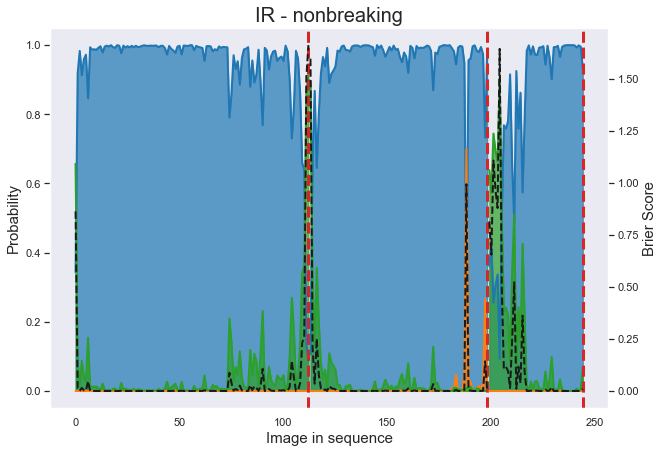

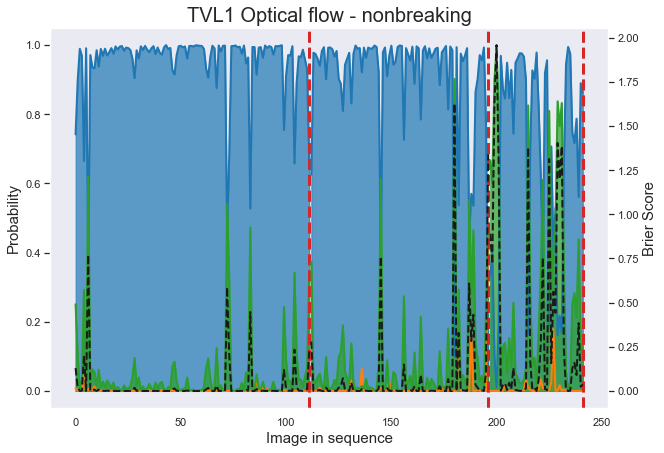

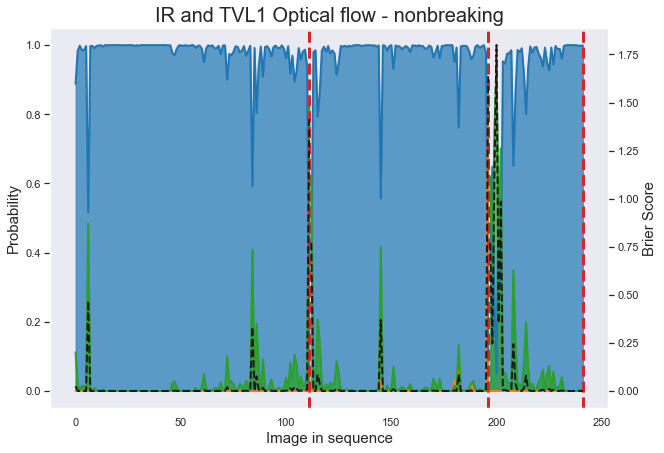

In [30]:
plot_wave_probs(IRnon, IRnon_brier, 'IR - nonbreaking')
plot_wave_probs(Flonon, Flonon_brier, 'TVL1 Optical flow - nonbreaking')
plot_wave_probs(IR_flonon, IR_flonon_brier, 'IR and TVL1 Optical flow - nonbreaking')

In [25]:
plungecat = []
for i in plunge_waves:
    plungecat = plungecat + i

In [130]:
#IR2plunge_prob, IR2plunge_brier = get_wave_probs('plunge', plunge_waves, 1, "IR2")
SPyplunge_prob, SPyplunge_brier = get_wave_probs('plunge', plunge_waves, 1, "SPy")

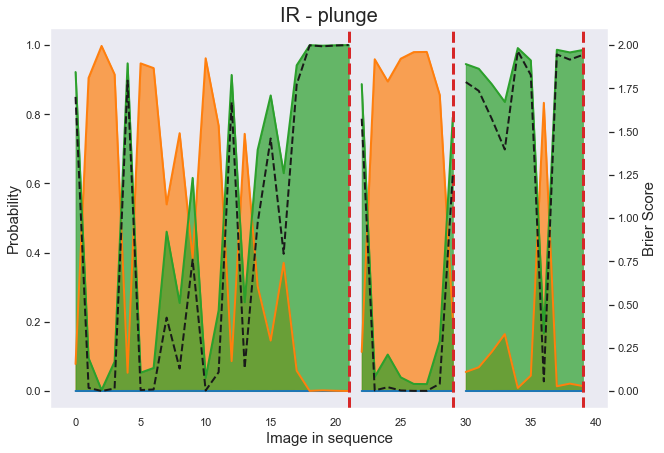

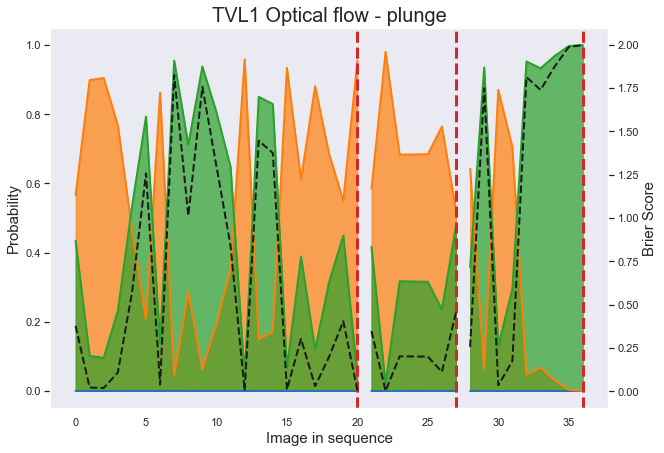

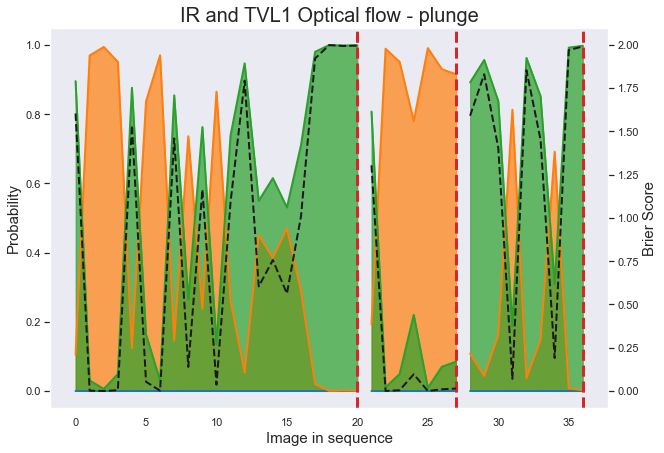

In [31]:
plot_wave_probs(IRplunge, IRplunge_brier, 'IR - plunge')
plot_wave_probs(Floplunge, Floplunge_brier, 'TVL1 Optical flow - plunge')
plot_wave_probs(IR_floplunge, IR_floplunge_brier, 'IR and TVL1 Optical flow - plunge')

In [133]:
IR2spill, IR2spill_brier = get_wave_probs('spill', spill_waves, 2, "IR2")
#SPyspill, SPyspill_brier = get_wave_probs('spill', spill_waves, 2, "SPy")

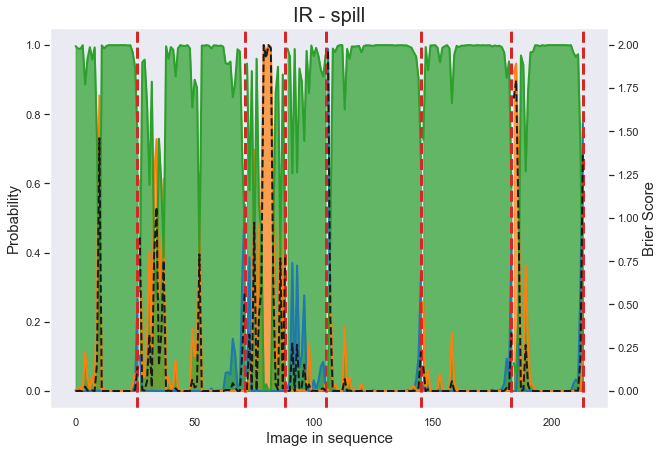

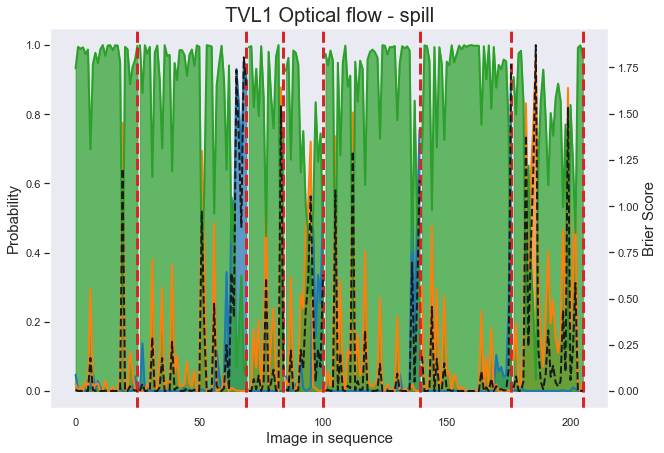

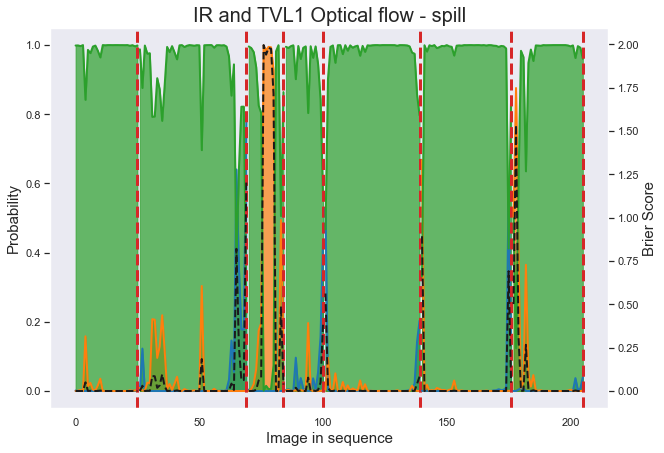

In [34]:
plot_wave_probs(IRspill, IRspill_brier, 'IR - spill')
plot_wave_probs(Flospill, Flospill_brier, 'TVL1 Optical flow - spill')
plot_wave_probs(IR_flospill, IR_flospill_brier, 'IR and TVL1 Optical flow - spill')

In [134]:
def print_brier(brier):
    brier = reduce(operator.add, brier)
    return np.round(np.mean(brier),2)
    
    
l = [IRplunge_brier,
     Floplunge_brier,
     IR2plunge_brier,
     IR_floplunge_brier,
     SPyplunge_brier,
     IRspill_brier,
     Flospill_brier,
     IR2spill_brier,
     IR_flospill_brier,
     SPyspill_brier,
     IRnon_brier,
     Flonon_brier,
     IR2non_brier,
     IR_flonon_brier,
     SPynon_brier]

r = ["IR     - plunge brier \t:\t",
     "Flo    - plunge brier \t:\t",
     "IR+IR  - plunge brier \t:\t",
     "IR+Flo - plunge brier \t:\t",
     "SPyFlo - plunge brier \t:\t",
     "IR     - spill brier \t:\t",
     "Flo    - spill brier \t:\t",
     "IR+IR  - spill brier \t:\t",
     "IR+Flo - spill brier \t:\t",
     "SPyFlo - non brier \t:\t",
     "IR     - non brier \t:\t",
     "Flo    - non brier \t:\t",
     "IR_IR  - non brier \t:\t",
     "IR+Flo - non brier \t:\t",
     "SPyFlo - non brier \t:\t"]

for i,j in zip(l,r):
    print(j ,print_brier(i))

IR     - plunge brier 	:	 0.97
Flo    - plunge brier 	:	 0.7
IR+IR  - plunge brier 	:	 1.01
IR+Flo - plunge brier 	:	 0.91
SPyFlo - plunge brier 	:	 0.92
IR     - spill brier 	:	 0.22
Flo    - spill brier 	:	 0.22
IR+IR  - spill brier 	:	 0.24
IR+Flo - spill brier 	:	 0.12
SPyFlo - non brier 	:	 0.33
IR     - non brier 	:	 0.09
Flo    - non brier 	:	 0.06
IR_IR  - non brier 	:	 0.08
IR+Flo - non brier 	:	 0.05
SPyFlo - non brier 	:	 0.06


# Clustering

In [36]:
def get_feat_lab(feat_path, lab_path):
    feat = h5py.File(feat_path, 'r')
    lab = h5py.File(lab_path, 'r')
    
    feat = feat['dataset_1']
    lab = lab['dataset_1']
    return feat, lab

In [52]:
train_IR, train_IRlab = get_feat_lab('out/xception/h5files/IRfeatures.h5', 'out/xception/h5files/IRlabels.h5')
train_flo, train_flolab = get_feat_lab('out/xception/h5files/Flofeatures.h5','out/xception/h5files/Flolabels.h5')
train_IRflo, train_IRflolab = get_feat_lab('out/xception/h5files/IR_flo_features.h5', 'out/xception/h5files/IR2flo_labels.h5')

In [64]:
from sklearn.decomposition import PCA

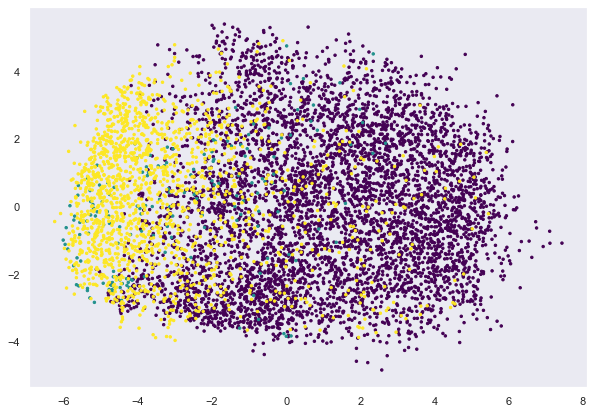

In [63]:
pca = PCA(n_components=2)
pc = pca.fit_transform(train_IR)
plt.scatter(pc[:,0], pc[:,1], c=train_IRlab, s=6, label=train_IRlab, cmap='viridis')

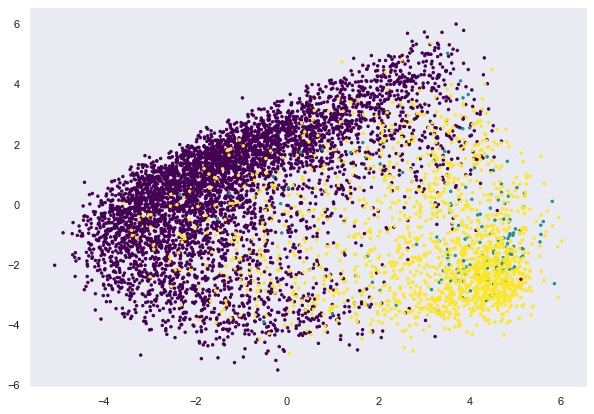

In [65]:
pca = PCA(n_components=2)
pc = pca.fit_transform(train_flo)
plt.scatter(pc[:,0], pc[:,1], c=train_flolab, s=6, label=train_flolab, cmap='viridis')

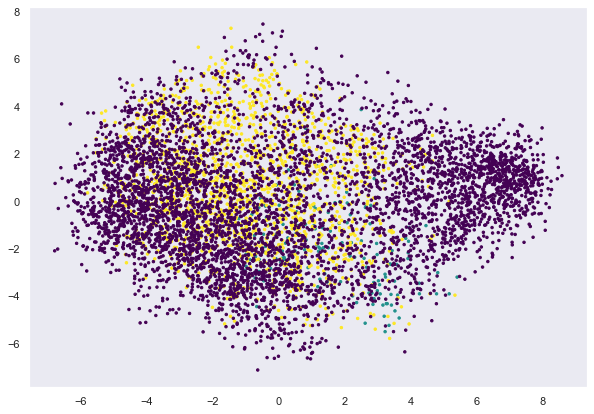

In [66]:
pca = PCA(n_components=2)
pc = pca.fit_transform(train_IRflo)
plt.scatter(pc[:,0], pc[:,1], c=train_IRflolab, s=6, label=train_IRflolab, cmap='viridis')

In [67]:
def umap_clust(features):
    cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, 
                          n_components=2, random_state=1).fit_transform(features)
    return cluster

def umap_plot(cluster, label, title, save=None, **kwargs):
    fig, ax = plt.subplots(**kwargs)
    scatter = ax.scatter(cluster[:, 0], cluster[:, 1], marker = 'D',
                c=label, s=10, label=label, cmap='viridis')
    plt.legend(handles=scatter.legend_elements()[0], labels=["nonbreaking", "plunge","spill"], title='classes', prop={'size': 16})
    plt.title(title)
    plt.axis('off')
    
    if save:
        plt.savefig(save)
    plt.show()

def pl_sp(features, labels):
    new_data = np.array([])
    new_label = np.array([])
    for i, lab in enumerate(labels):
        if lab != 0:
            new_data = np.append(new_data, features[i])
            new_label = np.append(new_label, lab)
    new_data = np.reshape(new_data, (len(new_data)//np.shape(features)[1], np.shape(features)[1]))
    return new_data, new_label

In [71]:
IR_train_ps, IR_train_labps = pl_sp(train_IR, train_IRlab)
Flo_train_ps, Flo_train_labps = pl_sp(train_flo, train_flolab)
IRFlo_train_ps, IRFlo_train_labps = pl_sp(train_IRflo, train_IRflolab)

In [72]:
IR_cluster_ps = umap_clust(IR_train_ps)
Flo_cluster_ps = umap_clust(Flo_train_ps)
IRFlo_cluster_ps = umap_clust(IRFlo_train_ps)

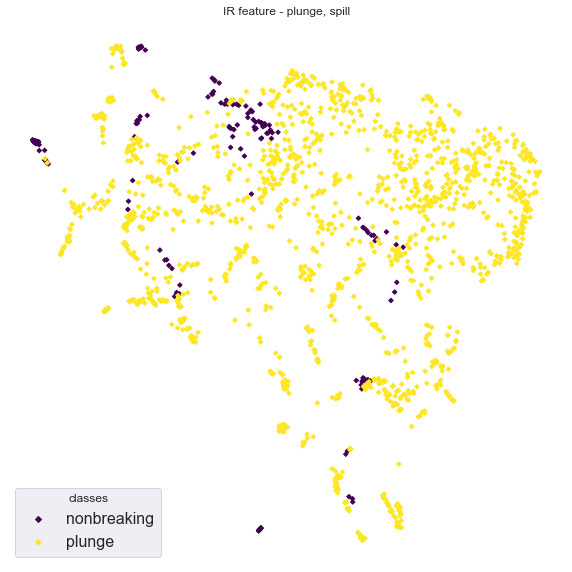

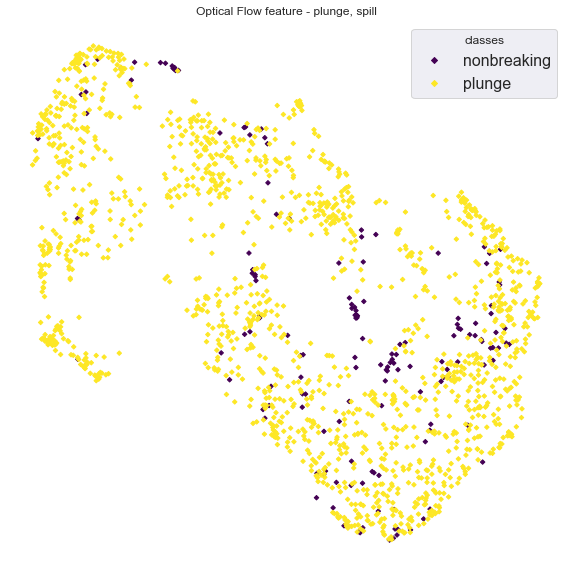

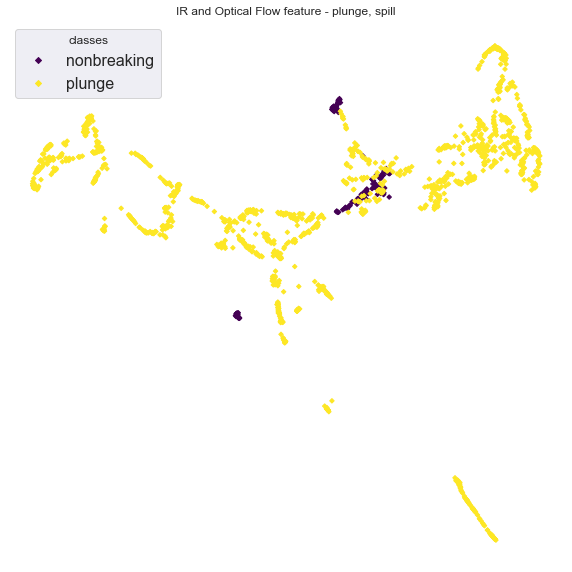

In [73]:
umap_plot(IR_cluster_ps, IR_train_labps, 'IR feature - plunge, spill',
         save='IR_cluster_PS', figsize=(10,10))
umap_plot(Flo_cluster_ps, Flo_train_labps, 'Optical Flow feature - plunge, spill',
         save='OF_cluster_PS', figsize=(10,10))
umap_plot(IRFlo_cluster_ps, IRFlo_train_labps, 'IR and Optical Flow feature - plunge, spill',
        save='IR_OF_cluster_PS', figsize=(10,10))

In [70]:
IR_cluster = umap_clust(train_IR)
flo_cluster = umap_clust(train_flo)
IRflo_cluster = umap_clust(train_IRflo)
IRflo_cluster = umap_clust(train_IRflo)

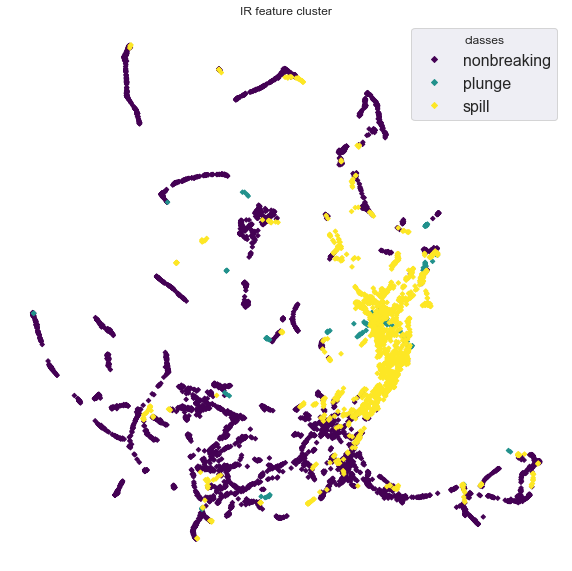

In [74]:
umap_plot(IR_cluster, train_IRlab, 'IR feature cluster', 
        save='IR_features_cluster.png', figsize=(10,10))

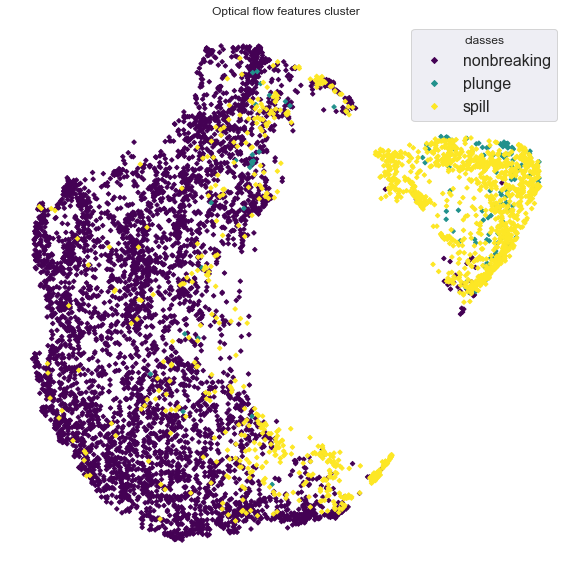

In [75]:
umap_plot(flo_cluster, train_flolab, 'Optical flow features cluster',
          'OpticalFlow_features_cluster.png', figsize=(10,10))

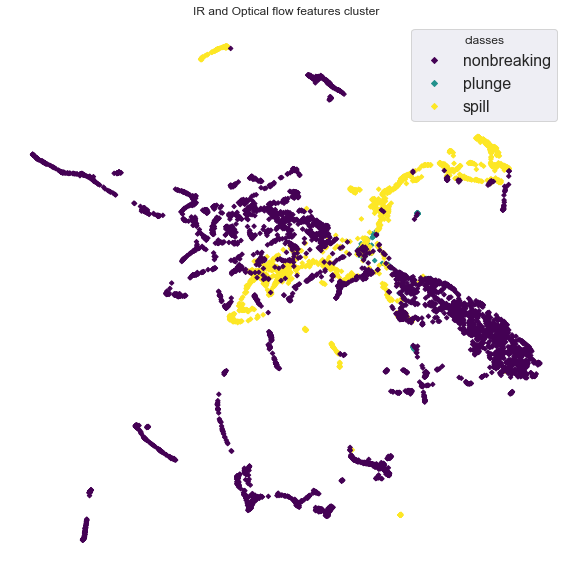

In [76]:
umap_plot(IRflo_cluster, train_IRflolab, 'IR and Optical flow features cluster',
          'IR_OpticalFlow_features_cluster.png', figsize=(10,10))

# Augmented Clustering

In [78]:
aug_train_IR = h5py.File('out/xception/h5files/IRfeatures_imaug.h5', 'r')
aug_train_IR = aug_train_IR['dataset_1']
aug_train_IRlab = h5py.File('out/xception/h5files/IRlabels_imaug.h5', 'r')
aug_train_IRlab = aug_train_IRlab['dataset_1']

aug_train_flo = h5py.File('out/xception/h5files/Flofeatures_imaug.h5', 'r')
aug_train_flo = aug_train_flo['dataset_1']
aug_train_flolab = h5py.File('out/xception/h5files/Flolabels_imaug.h5', 'r')
aug_train_flolab = aug_train_flolab['dataset_1']

augtrain_IRflo = h5py.File('out/xception/h5files/IR_flo_features_imaug.h5', 'r')
augtrain_IRflo = augtrain_IRflo['dataset_1']
augtrain_IRflolab = h5py.File('out/xception/h5files/IR_flo_labels_imaug.h5', 'r')
augtrain_IRflolab = augtrain_IRflolab['dataset_1']


In [79]:
augIR_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=1).fit_transform(aug_train_IR)
augflo_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=1).fit_transform(aug_train_flo)
augIRflo_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, 
                               n_components=2, random_state=1).fit_transform(augtrain_IRflo)

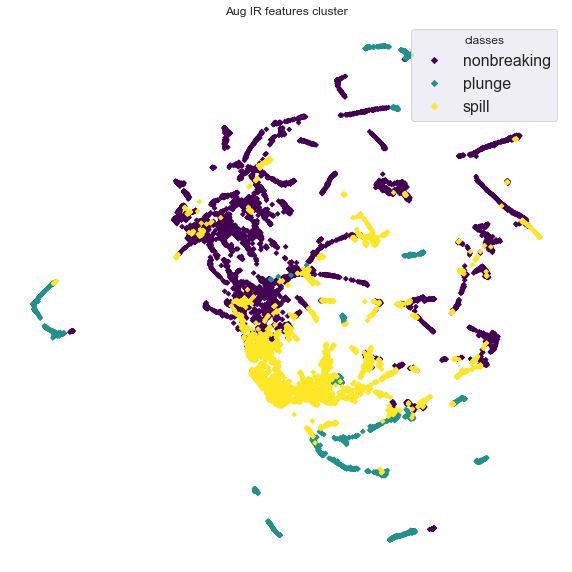

In [80]:
umap_plot(augIR_cluster, aug_train_IRlab, 'Aug IR features cluster',
          save = 'AUG_IR_features_cluster',figsize=(10,10))

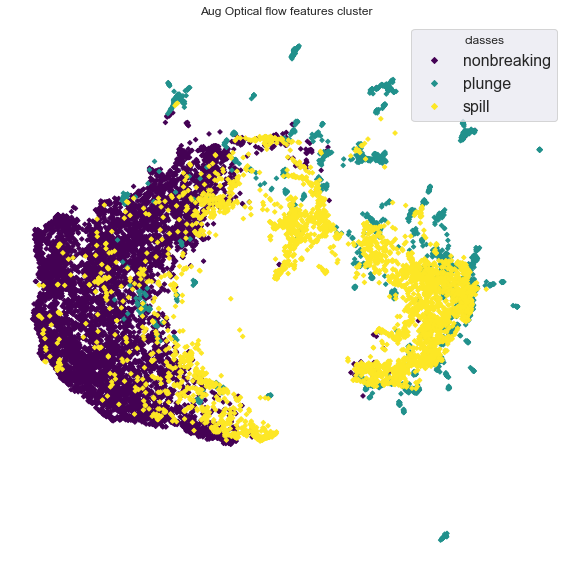

In [81]:
umap_plot(augflo_cluster, aug_train_flolab, 'Aug Optical flow features cluster',
          save='AUG_OF_features_cluster', figsize=(10,10))

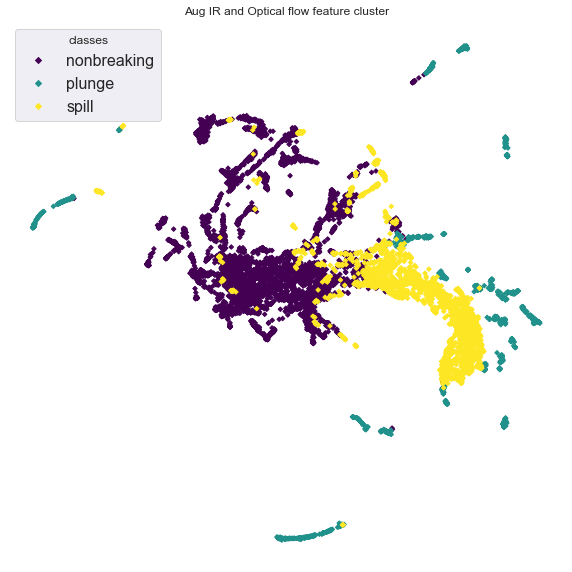

In [82]:
umap_plot(augIRflo_cluster, augtrain_IRflolab, 
        'Aug IR and Optical flow feature cluster',
          save = 'AUG_IR_OF_feautres_cluster',
         figsize=(10,10))